# Potato balances

In this notebook we will use the partial least squares balances to quantify differences between potato cultivars.

In [47]:
import pandas as pd
from statsmodels.sandbox.stats.multicomp import multipletests
from skbio import TreeNode
import seaborn as sns
import matplotlib.pyplot as plt
from gneiss.plot import balance_boxplot, balance_barplots, proportion_plot
from gneiss.util import match

from pls_balances.src.balances import balance_classify, round_balance
import numpy as np
import matplotlib
from biom import load_table
import re
import calour as ca


%matplotlib inline
np.random.seed(0)
#font = {'family' : 'normal'
#        'size'   : 16}

#matplotlib.rc('font', **font)

In [48]:
data_dir = '../data/potato_pls_wip/data'
table_file = '%s/MZMINE-aca8c00d-download_biom-main.biom' % data_dir
metadata_file = '%s/potato_untargeted_metabolomics_metadata.txt' % data_dir

table = load_table(table_file)
table = pd.DataFrame(np.array(table.matrix_data.todense()).T+1,
                     index=table.ids(axis='sample'),
                     columns=table.ids(axis='observation'))
metadata = pd.read_table(metadata_file, index_col=0)

# fix all of the table ids
pattern = re.compile(r'C18p_(\S+)_5ul\S+ Peak area') 
f = lambda x: pattern.findall(x)[0]
table.index = [f(i) for i in table.index]

table, metadata = match(table, metadata)

# set the colors
purple_color = '#A569BD' 
white_color = '#B3B6B7' 
red_color = '#F1948A' 

fried_color = '#F39C12'
not_fried_color = '#3498DB'
metadata['Fried'] = np.logical_or(metadata['processing_type']=='Chips',
                                  metadata['processing_type']=='FrenchFried')

We'll want to first apply standard PLS to see if there are really obvious patterns with respect to the cultivar color.

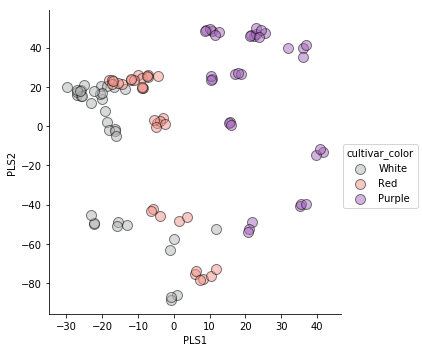

In [49]:
from sklearn.cross_decomposition import PLSRegression
from skbio.stats.composition import clr, centralize, multiplicative_replacement


class_purple = (metadata.cultivar_color == 'Purple').values
class_white = (metadata.cultivar_color == 'White').values
class_red = (metadata.cultivar_color == 'Red').values

Y = np.vstack((class_purple, 
               np.logical_or(class_red, class_white))).astype(np.int).T


ctable = pd.DataFrame(clr(centralize(table)), 
                      index=table.index, columns=table.columns)

color_pls = PLSRegression(n_components=2)
color_pls.fit(X=ctable.values, Y=Y)
scores = pd.DataFrame(color_pls.x_scores_, 
                      columns=['PLS1', 'PLS2'], index=table.index)
data = pd.merge(scores, metadata, left_index=True, right_index=True)

# Create scatterplot of dataframe
_ = sns.lmplot('PLS1', # Horizontal axis
               'PLS2', # Vertical axis
               data=data, # Data source
               fit_reg=False, # Don't fix a regression line
               hue="cultivar_color", # Set color
               palette={'Purple':purple_color, 'Red':red_color, 'White':white_color},
               scatter_kws={"marker": "o", # Set marker style
                            "s": 100, 'alpha': 0.5, 'edgecolor':'k'}) # S marker size

Now let's apply this to the processing type to see if we can differentiate between fried and other potatoes.

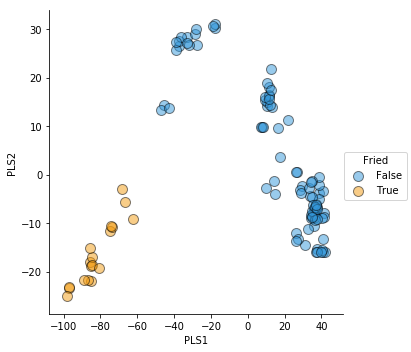

In [50]:
from sklearn.cross_decomposition import PLSRegression
from skbio.stats.composition import clr, centralize, multiplicative_replacement

Yf = np.vstack((metadata.Fried.values, 
               ~metadata.Fried.values)).astype(np.int).T

ctable = pd.DataFrame(clr(centralize(table)), 
                      index=table.index, columns=table.columns)

fried_pls = PLSRegression(n_components=2)
fried_pls.fit(X=ctable.values, Y=Yf)
scores = pd.DataFrame(fried_pls.x_scores_, 
                      columns=['PLS1', 'PLS2'], index=table.index)
data = pd.merge(scores, metadata, left_index=True, right_index=True)

# Create scatterplot of dataframe
_ = sns.lmplot('PLS1', # Horizontal axis
               'PLS2', # Vertical axis
               data=data, # Data source
               fit_reg=False, # Don't fix a regression line
               hue="Fried", # Set color
               palette={True:fried_color, False:not_fried_color},
               scatter_kws={"marker": "o", # Set marker style
                            "s": 100, 'alpha': 0.5, 'edgecolor':'k'}) # S marker size

Below, we will fit Gaussian Mixture Models on the PLS loadings, and see how well they fit.

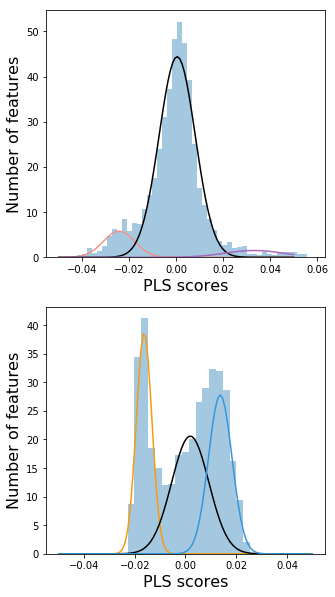

In [64]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

fig, (ax_c, ax_p) = plt.subplots(2, 1, figsize=(5, 10))

# PLS on the colors
color_pls = PLSRegression(n_components=1)
color_pls.fit(X=ctable.values, Y=Y)
color_spectrum = pd.DataFrame(color_pls.x_weights_, index=ctable.columns, columns=['PLS1'])

color_mixture = GaussianMixture(n_components=3, 
                                 means_init=np.array([[-0.05], [0], [0.05]]), 
                                 random_state=0)
color_mixture.fit(X=color_spectrum.values)

color_m = np.ravel(color_mixture.means_)
color_s = np.ravel(np.sqrt(color_mixture.covariances_)) 
color_w = np.ravel(color_mixture.weights_)

x = np.linspace(-0.05, 0.05, 100)
sns.distplot(color_spectrum, norm_hist=True, kde=False, ax=ax_c)
ax_c.plot(x, color_w[0]*norm.pdf(x, color_m[0], color_s[0]), red_color)
ax_c.plot(x, color_w[1]*norm.pdf(x, color_m[1], color_s[1]), '-k')
ax_c.plot(x, color_w[2]*norm.pdf(x, color_m[2], color_s[2]), purple_color)
ax_c.set_xlabel('PLS scores', fontsize=16)
ax_c.set_ylabel('Number of features', fontsize=16)

# PLS on the processing type
fried_pls = PLSRegression(n_components=1)
fried_pls.fit(X=ctable.values, Y=Yf)
fried_spectrum = pd.DataFrame(fried_pls.x_weights_, index=ctable.columns, columns=['PLS1'])

fried_mixture = GaussianMixture(n_components=3, 
                                 means_init=np.array([[-0.02], [0], [0.02]]), 
                                 random_state=0)
fried_mixture.fit(X=fried_spectrum.values)

fried_m = np.ravel(fried_mixture.means_)
fried_s = np.ravel(np.sqrt(fried_mixture.covariances_)) 
fried_w = np.ravel(fried_mixture.weights_)

x = np.linspace(-0.05, 0.05, 100)
sns.distplot(fried_spectrum, norm_hist=True, kde=False, ax=ax_p)
ax_p.plot(x, fried_w[0]*norm.pdf(x, fried_m[0], fried_s[0]), fried_color)
ax_p.plot(x, fried_w[1]*norm.pdf(x, fried_m[1], fried_s[1]), '-k')
ax_p.plot(x, fried_w[2]*norm.pdf(x, fried_m[2], fried_s[2]), not_fried_color)e
ax_p.set_xlabel('PLS scores', fontsize=16)
ax_p.set_ylabel('Number of features', fontsize=16)


plt.savefig('../results/figures/figure3_potato_feature_histogram.pdf')

Now given what we have seen, it looks like we can fit pretty solid mixture models.  In addition, the purple peak seems very distinct from the red cultivar type.  And the fried vs not fried peaks appear to be separating very clearly.

With this diagnostic information, we'll apply the thresholds and learn a balance that will quantify the separation between the purple and the other cultivars.

Now we will perform cross validation to see how generalizable this model is, by performing 4 fold crossvaliation and calculating the AUROC for the test data set.  Note that this is only an indication of how well this dataset can train the partial least squares balances - if the AUC scores are low, then it is an indication that the dataset is suitable.  This could arise for a number of reasons, but likely due to heterogousity, or sample size.

In [52]:
cats = pd.Series(class_purple, index=metadata.index)
res = balance_classify(table+1, cats, num_folds=4, 
                       means_init=np.array([[-0.05], [0], [0.05]]) )
num, denom, color_balance, cv = res
cv

,Q2,AUROC
0,-11.8418,1
1,-17.443,1
2,-12.6148,1
3,-12.964,1


In [53]:
cv['AUROC'].mean()

1.0

In [56]:
cats = pd.Series(metadata.Fried.values, index=metadata.index)
res = balance_classify(table+1, 1-cats, num_folds=4, 
                       means_init=np.array([[-0.025], [0], [0.025]]))
num, denom, fried_balance, cv = res
cv

,Q2,AUROC
0,-62.6164,1
1,-76.6253,1
2,-101.849,1
3,-137.15,1


In [57]:
cv['AUROC'].mean()

1.0

As we can see, the classification accuracy is pretty darn good.  Let's try to visualize the actual separation using histograms.

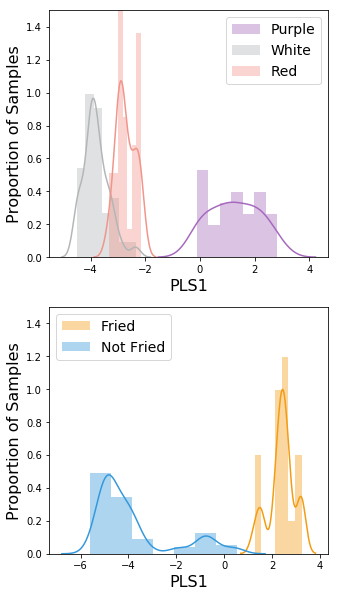

In [65]:
fig, (ax_c, ax_p) = plt.subplots(2, 1, figsize=(5, 10))
sns.distplot(color_balance[class_purple], 
             label='Purple', color=purple_color, bins=7, ax=ax_c)
sns.distplot(color_balance[class_white], 
             label='White', color=white_color, bins=7, ax=ax_c)
sns.distplot(color_balance[class_red], 
             label='Red', color=red_color, bins=7, ax=ax_c)
ax_c.legend(fontsize=14) 
ax_c.set_ylabel('Proportion of Samples', fontsize=16)
ax_c.set_xlabel('PLS1', fontsize=16)
ax_c.set_ylim([0, 1.5])

sns.distplot(efried_balance[metadata.Fried], 
             label='Fried', color=fried_color, bins=7, ax=ax_p)
sns.distplot(fried_balance[~metadata.Fried], 
             label='Not Fried', color=not_fried_color, bins=7, ax=ax_p)
ax_p.legend(fontsize=14) 
ax_p.set_ylabel('Proportion of Samples', fontsize=16)
ax_p.set_xlabel('PLS1', fontsize=16)
ax_p.set_ylim([0, 1.5])


plt.savefig('../results/figures/figure3_potato_sample_histogram.pdf')

In [66]:
from scipy.stats import f_oneway
from sklearn.metrics import roc_curve

color_fpr, color_tpr, color_thresholds = roc_curve(y_true=1-color_var.astype(int), 
                                                   y_score=color_balance)
fried_fpr, fried_tpr, fried_thresholds = roc_curve(y_true=fried_var.astype(int), 
                                                   y_score=fried_balance)

color_f, color_p = f_oneway(color_balance.loc[class_purple],
                            color_balance.loc[~class_purple])
fried_f, fried_p = f_oneway(fried_balance.loc[metadata.Fried],
                            fried_balance.loc[~metadata.Fried])

print('Purple vs Others \t -- F-statistic: %f \t p-value: \t %E' % (color_f, color_p))
print('Fried vs Others \t -- F-statistic: %f \t p-value: \t %E' % (fried_f, fried_p))

Purple vs Others 	 -- F-statistic: 839.544169 	 p-value: 	 6.740056E-52
Fried vs Others 	 -- F-statistic: 258.357202 	 p-value: 	 4.546201E-30


In [ ]:
writer = pd.ExcelWriter('../results/potato_stats.xlsx')

color_stats = pd.Series([auc(color_tpr, color_fpr), cv['AUROC'].mean(), color_f, color_p],
                  index=['AUC', 'AUC_CV', 'F-statistic', 'p-value'])
fried_stats = pd.Series([auc(fried_tpr, fried_fpr), cv['AUROC'].mean(), fried_f, fried_p],
                  index=['AUC', 'AUC_CV', 'F-statistic', 'p-value'])

x = cv['AUROC'].to_excel(writer, sheet_name='cv', index_label='folds')
stats.to_excel(writer, sheet_name='summary', header=False)
writer.save()

In [ ]:
import matplotlib

def rgb2hex(x):
    return '#%02x%02x%02x' % (int(x[0]*255), int(x[1]*255), int(x[2]*255))

num = num.sort_values(by='PLS1')
denom = denom.sort_values(by='PLS1')

f_ids = list(num.index) + list(denom.index) + list(set(potato_spectrum.index) - (set(num.index) | set(denom.index)))

n = len(num.index) 
d = len(denom.index)
o = len(f_ids) - n - d

cmap = matplotlib.cm.get_cmap('RdYlBu')
norm = matplotlib.colors.Normalize(vmin=metadata.cultivar_color.min(), 
                                   vmax=metadata.cultivar_color.max())
metadata = metadata.sort_values(by='cultivar_color')
s_ids = list(metadata.index)
potato_colors = pd.Series([purple_color]*metadata.cultivar_color.value_counts()['Purple'] + 
                          [red_color]*metadata.cultivar_color.value_counts()['Red'] + 
                          [white_color]*metadata.cultivar_color.value_counts()['White'],
                          index=s_ids,
                          name='Samples')

feature_colors = pd.Series([purple_color]*n + [white_color]*d + ['#FDFEFE']*o,
                           index=f_ids, name='Features')

In [ ]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [ ]:
def color_part(x):
    if x in num.index:
        return 'num'
    elif x in denom.index:
        return 'denom'
    else:
        return 'None'
feature_metadata = pd.DataFrame({
    'PLS': potato_spectrum.PLS1,
    'color_part': [color_part(x) for x in potato_spectrum.index]})

In [ ]:
table, metadata = match(table, metadata)

In [ ]:
exp = ca.experiment.Experiment(data=table.values+1,
                               sample_metadata=metadata, 
                               feature_metadata=feature_metadata)
exp = exp.center_log()

In [ ]:
%matplotlib notebook

In [ ]:
exp2 = exp.filter_by_metadata('color_part', ['num', 'denom'], axis='f')
exp2 = exp2.sort_by_metadata('processing_type', axis='s')
exp2 = exp2.sort_by_metadata('cultivar_color', axis='s')
exp2 = exp2.sort_by_metadata('PLS', axis='f')
exp2 = exp2.sort_by_metadata('color_part', axis='f')

exp2.plot(sample_color_bars=['cultivar_color'], feature_color_bars=['color_part'],
          cmap='seismic', norm=MidpointNormalize(midpoint=0), feature_field=None,
          sample_highlight_colors={'Purple': '#BB8FCE', 'Red': '#EC7063', 'White': '#D5D8DC'},
          feature_highlight_colors={'num': '#8E44AD', 'denom': '#95A5A6'}, barwidth=0.6,
          label_kwargs={'fontsize': 14, 'color':'black', 'weight': 'medium'}
         )

# Test for frying